# Marco Casalbore - PhD Course: Generative Deep Learning

In [1]:
# Jupyter setup
%matplotlib inline

from concurrent.futures import ThreadPoolExecutor

# Standard Python libs
import random
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
from tqdm import tqdm  # progress bar

# SciKit Learn
from sklearn import datasets
from sklearn.decomposition import PCA

# Deep Learning / Quantum Tools (se ti servono)
import tensorflow as tf
from qutip import *

# Qiskit core (versione 2.x, solo simulazione)
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "16"  # o 16 se vuoi usare tutti i thread logici

In [3]:
# --------------------------------------------------
# The following section we prepare the MNIST dataset
# and normalize the dataset to be in the bound 0-1
# Following this, the data is transformed using the 
# PCA algorithm down to k dimensions 
# --------------------------------------------------
test_images,test_labels = tf.keras.datasets.mnist.load_data()
train_images = test_images[0].reshape(60000,784)
train_labels = test_images[1]
labels = test_images[1]
train_images = train_images/255

# --------------------------------------------------
# ---------------- PCA Section ---------------------
# --------------------------------------------------
k=2
pca = PCA(n_components=k)
pca.fit(train_images)
pca_data = pca.transform(train_images)[:10000]
train_labels = train_labels[:10000]
t_pca_data = pca_data.copy()
pca_descaler = [[] for _ in range(k)]

for i in range(k):
    if pca_data[:,i].min() < 0:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] += np.abs(pca_data[:,i].min())
    else:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] -= pca_data[:,i].min()
    pca_descaler[i].append(pca_data[:,i].max())
    pca_data[:,i] /= pca_data[:,i].max()

# --------------------------------------------------
# -----  Transform PCA data to rotations ----------
# --------------------------------------------------
pca_data_rot= 2*np.arcsin(np.sqrt(pca_data))
#valid_labels = None
#valid_labels = train_labels==9
valid_labels = train_labels == 1 

pca_data_rot = pca_data_rot[valid_labels]
pca_data = pca_data[valid_labels]

print(f"The Total Explained Variance of {k} Dimensions is {sum(pca.explained_variance_ratio_).round(3)}")

# --------------------------------------------------
# Define a function that can take in PCA'ed data and return an image
# --------------------------------------------------
def descale_points(d_point,scales=pca_descaler,tfrm=pca):
    for col in range(d_point.shape[1]):
        d_point[:,col] *= scales[col][1]
        d_point[:,col] += scales[col][0]
    reconstruction = tfrm.inverse_transform(d_point)
    return reconstruction

The Total Explained Variance of 2 Dimensions is 0.168


In [4]:
#All functions needed for the functionality of the circuit simulation
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      dp = np.array((predictions[i] * 127.5) + 127.5).astype('uint8')
      plt.imshow(dp)
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
    

    
def ran_ang():
    #return np.pi/2
    return np.random.rand()*np.pi

def single_qubit_unitary(circ_ident,qubit_index,values):
    circ_ident.ry(values[0],qubit_index)

def dual_qubit_unitary(circ_ident,qubit_1,qubit_2,values):
    circ_ident.ryy(values[0],qubit_1,qubit_2)

def controlled_dual_qubit_unitary(circ_ident,control_qubit,act_qubit,values):
    circ_ident.cry(values[0],control_qubit,act_qubit)
    #circ_ident.cry(values[0],act_qubit,control_qubit)
    
def traditional_learning_layer(circ_ident,num_qubits,values,style="Dual",qubit_start=1,qubit_end=5):
    if style == "Dual":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
        for qub in np.arange(qubit_start,qubit_end-1):
            dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+","+str(qub+1)])
    elif style =="Single":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
    elif style=="Controlled-Dual":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
        for qub in np.arange(qubit_start,qubit_end-1):
            dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+","+str(qub+1)])
        for qub in np.arange(qubit_start,qubit_end-1):
            controlled_dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+"--"+str(qub+1)])

def data_loading_circuit(circ_ident,num_qubits,values,qubit_start=1,qubit_end=5):
    k = 0
    for qub in np.arange(qubit_start,qubit_end):
        circ_ident.ry(values[k],qub)
        k += 1

def swap_test(circ_ident,num_qubits):
    num_swap = num_qubits//2
    for i in range(num_swap):
        circ_ident.cswap(0,i+1,i+num_swap+1)
    circ_ident.h(0)
    circ_ident.measure(0,0)
        
def init_random_variables(q,style):
    trainable_variables = {}
    if style=="Single":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
    elif style=="Dual":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
            if i != q:
                trainable_variables[str(i)+","+str(i+1)] = [ran_ang()]
    elif style=="Controlled-Dual":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
            if i != q:
                trainable_variables[str(i)+","+str(i+1)] = [ran_ang()]
                trainable_variables[str(i)+"--"+str(i+1)] = [ran_ang()]
    return trainable_variables
    
def get_probabilities(circ, counts=5000):
    circ_t = transpile(circ, backend)

    job = backend.run(circ_t, shots=counts)
    result = job.result()
    counts = result.get_counts(circ_t)

    try:
        prob = counts.get('0', 0) / (counts.get('0', 0) + counts.get('1', 0))
        prob = prob - 0.5
        if prob <= 0.005:
            prob = 0.005
        else:
            prob = prob * 2
    except:
        prob = 1
    return prob
        
# Define loss function. SWAP Test returns probability, so minmax probability is logical
def cost_function(p,yreal,trimming):
    if yreal == 0:
        return -np.log(p)
        #return 1-p
    elif yreal == 1:
        return -np.log(1-p)
        #return p
    
def generator_cost_function(p):
    return -np.log(p)

def update_weights(init_value,lr,grad):
    while lr*grad > 2*np.pi:
        lr /= 10
        print("Warning - Gradient taking steps that are very large. Drop learning rate")
    weight_update = lr*grad
    new_value = init_value
    print("Updating with a new value of " + str(weight_update))
    if new_value-weight_update > 2*np.pi:
        new_value = (new_value-weight_update) - 2*np.pi
    elif new_value-weight_update < 0:
        new_value = (new_value-weight_update) + 2*np.pi
    else:
        new_value = new_value - weight_update
    return new_value 

# Define loss function. SWAP Test returns probability, so minmax probability is logical
def cost_function(p,yreal,trimming):
    if yreal == 0:
        return -np.log(p)
        #return 1-p
    elif yreal == 1:
        return -np.log(1-p)
        #return p
    
def generator_cost_function(p):
    return -np.log(p)

def update_weights(init_value,lr,grad):
    while lr*grad > 2*np.pi:
        lr /= 10
        print("Warning - Gradient taking steps that are very large. Drop learning rate")
    weight_update = lr*grad
    new_value = init_value
    print("Updating with a new value of " + str(weight_update))
    if new_value-weight_update > 2*np.pi:
        new_value = (new_value-weight_update) - 2*np.pi
    elif new_value-weight_update < 0:
        new_value = (new_value-weight_update) + 2*np.pi
    else:
        new_value = new_value - weight_update
    return new_value 

In [5]:
# ------------------------------------------------------------------------------------
# We treat the first n qubits are the discriminators state. n is always defined as the
# integer division floor of the qubit count.
# This is due to the fact that a state will always be k qubits, therefore the 
# number of total qubits must be 2k+1. 2k as we need k for the disc, and k to represent
# either the other learned quantum state, or k to represent a data point
# then +1 to perform the SWAP test. Therefore, we know that we will always end up
# with an odd number of qubits. We take the floor to solve for k. 1st k represents 
# disc, 2nd k represents the "loaded" state be it gen or real data
# ------------------------------------------------------------------------------------
# Use different function calls to represent training a GENERATOR or training a DISCRIMINATOR
# ------------------------------------------------------------------------------------
# THIS SECTION IS FOR THE ONLINE GENERATION OF QUANTUM CIRCUITS

def disc_fake_training_circuit(trainable_variables,key,key_value,diff=False,fwd_diff = False,Sample=False):
    if Sample:
        z = q//2
        circ = QuantumCircuit(q,z)
    else:
        circ = QuantumCircuit(q,c)
    circ.h(0)
    if diff == True and fwd_diff == True:
        trainable_variables[key][key_value] += par_shift
    if diff == True and fwd_diff == False:
        trainable_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ,q,trainable_variables,style=layer_style,qubit_start=1,qubit_end=q//2 +1)
    traditional_learning_layer(circ,q,trainable_variables,style=layer_style,qubit_start=q//2 +1,qubit_end=q)
    if Sample:
        for qub in range(q//2):
            circ.measure(q//2 + 1 + qub,qub)
    else:
        swap_test(circ,q)
    if diff == True and fwd_diff == True:
        trainable_variables[key][key_value] -= par_shift
    if diff == True and fwd_diff == False:
        trainable_variables[key][key_value] += par_shift
    return circ

def disc_real_training_circuit(training_variables,data,key,key_value,diff,fwd_diff):
    circ = QuantumCircuit(q,c)
    circ.h(0)
    if diff == True & fwd_diff == True:
        training_variables[key][key_value] += par_shift
    if diff == True & fwd_diff == False:
        training_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ,q,training_variables,style=layer_style,qubit_start=1,qubit_end=q//2 +1)
    data_loading_circuit(circ,q,data,qubit_start=q//2 +1,qubit_end=q)
    if diff == True & fwd_diff == True:
        training_variables[key][key_value] -= par_shift
    if diff == True & fwd_diff == False:
        training_variables[key][key_value] += par_shift
    swap_test(circ,q)
    return circ

def generate_kl_divergence_hist(actual_data, epoch_results_data):
    plt.clf() # clears current figure
    sns.set()
    kl_div_vec = []
    for kl_dim in range(actual_data.shape[1]):
        kl_div = kl_divergence(actual_data[:,kl_dim],epoch_results_data[:,kl_dim])
        kl_div_vec.append(kl_div)
    return kl_div_vec

def bin_data(dataset):
    bins = np.zeros(10)
    for point in dataset:
        indx = int(str(point).split('.')[-1][0]) # The shittest way imaginable to extract the first val aft decimal
        bins[indx] +=1  
    bins /= sum(bins)
    return bins

def kl_divergence(p_dist, q_dist):
    p = bin_data(p_dist)
    q = bin_data(q_dist)
    kldiv = 0
    for p_point,q_point in zip(p,q):
        kldiv += (np.sqrt(p_point) - np.sqrt(q_point))**2
    kldiv = (1/np.sqrt(2))*kldiv**0.5 
    return kldiv
    #return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))  # ?... are we confident in this... 

    
# Checkpointing code
def save_variables(var_dict,epoch):
    with open(f"Epoch-{epoch}-Variables-numbers-9",'w') as file:
        file.write(str(train_var))

Starting Training
--------------------
Generator Loss: 0.5573154550356761
Discriminator Loss: 2.960686416845118
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:42<00:00,  7.34it/s]


Generation completed in 2340.64 seconds
Saved to generated_epoch_1.npy with shape (10000, 1, 28, 28)
Epoch 1 Generated Preview Images


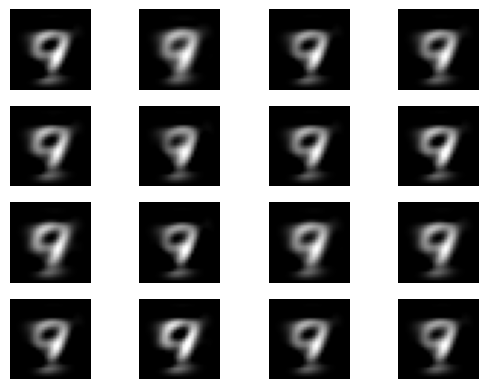

Epoch 1 completed in 2341.00 seconds
Generator Loss: 0.04398775656819752
Discriminator Loss: 4.358910288128592
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:02<00:00,  7.56it/s]


Generation completed in 2277.75 seconds
Saved to generated_epoch_2.npy with shape (10000, 1, 28, 28)
Epoch 2 Generated Preview Images


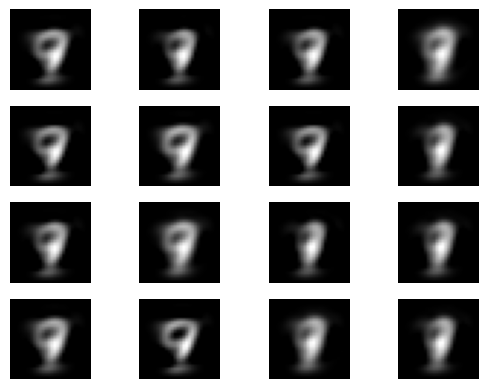

Epoch 2 completed in 2277.96 seconds
Generator Loss: 0.010190244906513272
Discriminator Loss: 5.471528549114056
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:00<00:00,  7.57it/s]


Generation completed in 2259.37 seconds
Saved to generated_epoch_3.npy with shape (10000, 1, 28, 28)
Epoch 3 Generated Preview Images


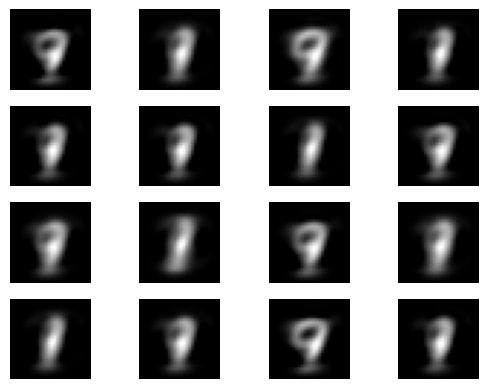

Epoch 3 completed in 2259.71 seconds
Generator Loss: 0.004059989285556566
Discriminator Loss: 6.15603734906443
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:02<00:00,  7.56it/s]


Generation completed in 2264.79 seconds
Saved to generated_epoch_4.npy with shape (10000, 1, 28, 28)
Epoch 4 Generated Preview Images


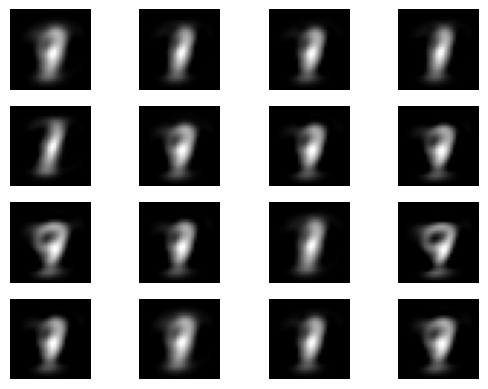

Epoch 4 completed in 2265.03 seconds
Generator Loss: 0.0020096232113988124
Discriminator Loss: 6.54177972016042
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:58<00:00,  7.58it/s]


Generation completed in 2257.58 seconds
Saved to generated_epoch_5.npy with shape (10000, 1, 28, 28)
Epoch 5 Generated Preview Images


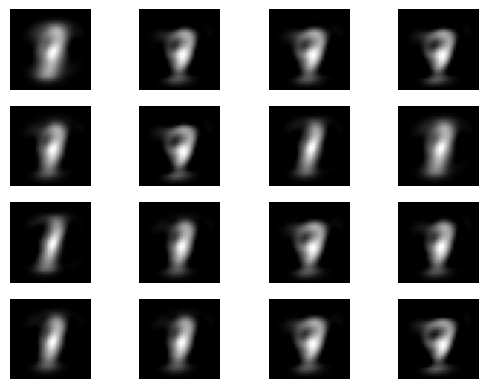

Epoch 5 completed in 2257.79 seconds
Generator Loss: 0.0012618810950641363
Discriminator Loss: 6.830794237845934
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:57<00:00,  7.59it/s]


Generation completed in 2292.75 seconds
Saved to generated_epoch_6.npy with shape (10000, 1, 28, 28)
Epoch 6 Generated Preview Images


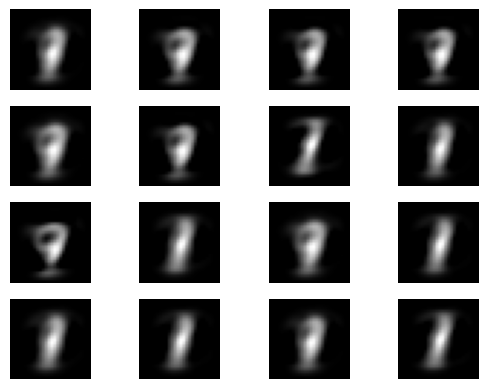

Epoch 6 completed in 2292.96 seconds
Generator Loss: 0.0009256528766520695
Discriminator Loss: 7.918796347402213
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:42<00:00,  7.68it/s]


Generation completed in 2247.49 seconds
Saved to generated_epoch_7.npy with shape (10000, 1, 28, 28)
Epoch 7 Generated Preview Images


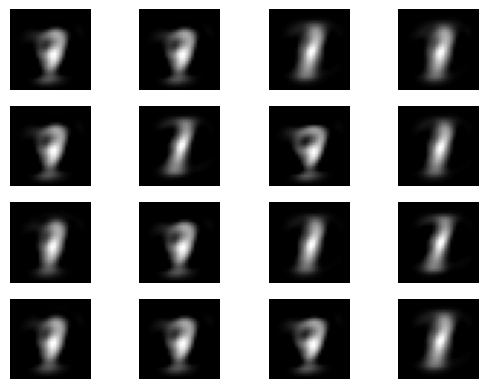

Epoch 7 completed in 2247.70 seconds


C:\Users\marco\AppData\Local\Temp\ipykernel_14596\1734610337.py:133: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)
C:\Users\marco\AppData\Local\Temp\ipykernel_14596\1086685205.py:48: RuntimeWarning: invalid value encountered in scalar divide
  df = df / abs(df)


Generator Loss: 0.0006002930916751398
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:46<00:00,  7.65it/s]


Generation completed in 2252.91 seconds
Saved to generated_epoch_8.npy with shape (10000, 1, 28, 28)
Epoch 8 Generated Preview Images


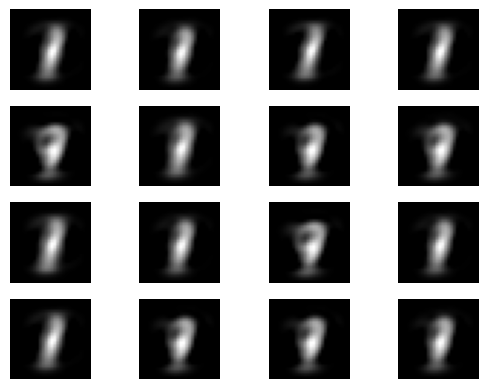

Epoch 8 completed in 2253.12 seconds
Generator Loss: 0.0005824180724122603
Discriminator Loss: 6.511613498334828
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:13<00:00,  7.50it/s]


Generation completed in 2287.96 seconds
Saved to generated_epoch_9.npy with shape (10000, 1, 28, 28)
Epoch 9 Generated Preview Images


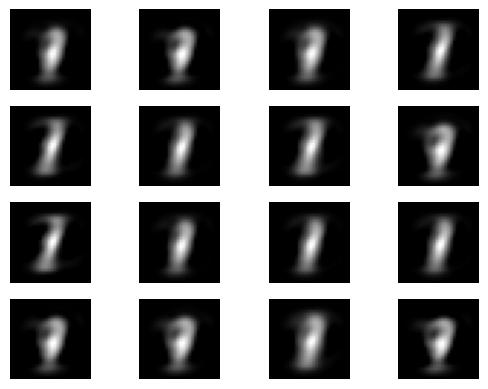

Epoch 9 completed in 2288.18 seconds
Generator Loss: 0.0003894465351366602
Discriminator Loss: 7.191498452425386
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:40<00:00,  7.69it/s]


Generation completed in 2264.18 seconds
Saved to generated_epoch_10.npy with shape (10000, 1, 28, 28)
Epoch 10 Generated Preview Images


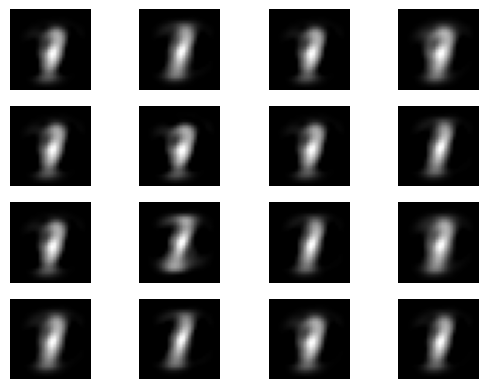

Epoch 10 completed in 2264.38 seconds
Generator Loss: 0.0003465593716988311
Discriminator Loss: 7.210808213524759
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:55<00:00,  7.60it/s]


Generation completed in 2270.23 seconds
Saved to generated_epoch_11.npy with shape (10000, 1, 28, 28)
Epoch 11 Generated Preview Images


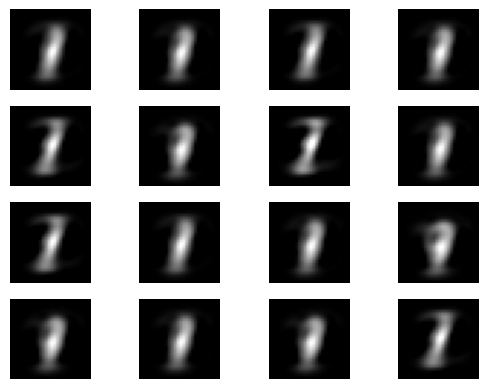

Epoch 11 completed in 2270.44 seconds
Generator Loss: 0.0002786586125955304
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:02<00:00,  7.56it/s]


Generation completed in 2269.64 seconds
Saved to generated_epoch_12.npy with shape (10000, 1, 28, 28)
Epoch 12 Generated Preview Images


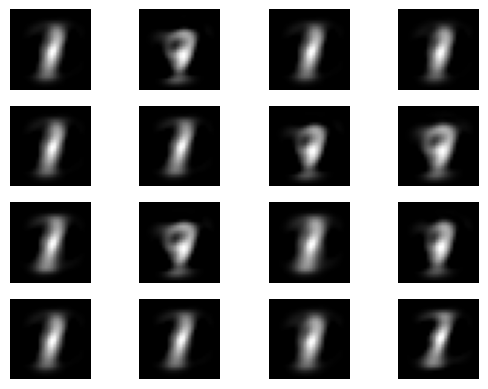

Epoch 12 completed in 2269.87 seconds
Generator Loss: 0.00024651218803137763
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:01<00:00,  7.57it/s]


Generation completed in 2264.14 seconds
Saved to generated_epoch_13.npy with shape (10000, 1, 28, 28)
Epoch 13 Generated Preview Images


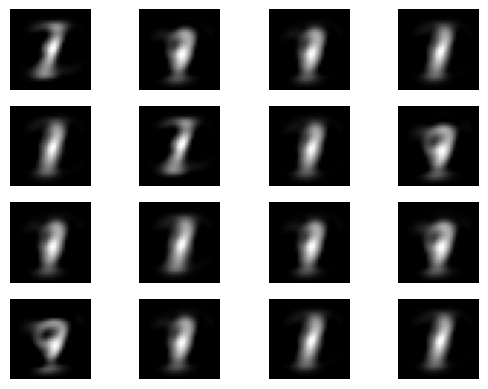

Epoch 13 completed in 2264.35 seconds
Generator Loss: 0.0002179250344994482
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:00<00:00,  7.57it/s]


Generation completed in 2264.51 seconds
Saved to generated_epoch_14.npy with shape (10000, 1, 28, 28)
Epoch 14 Generated Preview Images


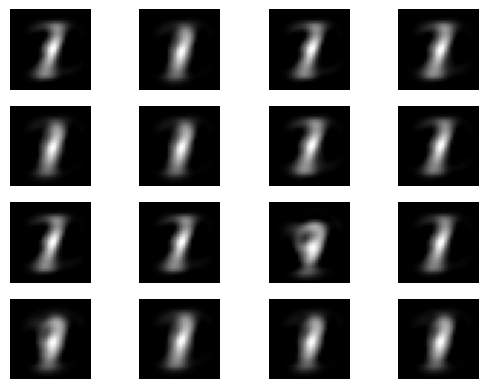

Epoch 14 completed in 2264.72 seconds
Generator Loss: 0.00018576287619983246
Discriminator Loss: 7.891040879680681
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:00<00:00,  7.57it/s]


Generation completed in 2264.91 seconds
Saved to generated_epoch_15.npy with shape (10000, 1, 28, 28)
Epoch 15 Generated Preview Images


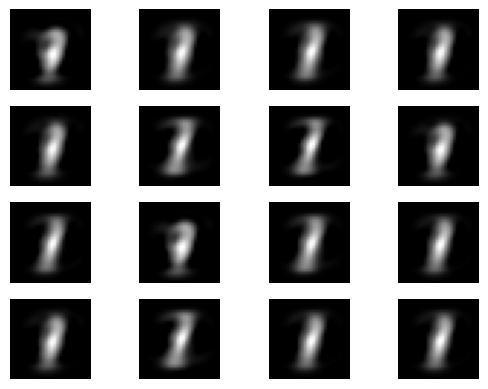

Epoch 15 completed in 2265.12 seconds
Generator Loss: 0.00013932930801514368
Discriminator Loss: 7.879558720786661
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:41<00:00,  7.69it/s]


Generation completed in 2239.61 seconds
Saved to generated_epoch_16.npy with shape (10000, 1, 28, 28)
Epoch 16 Generated Preview Images


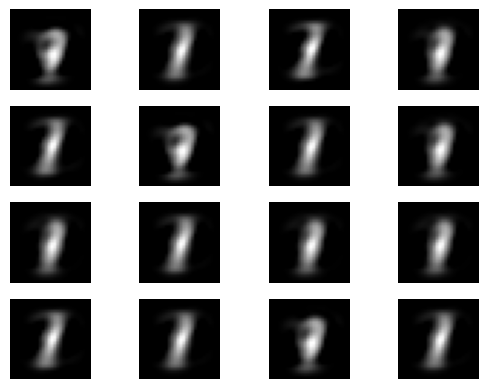

Epoch 16 completed in 2239.82 seconds
Generator Loss: 0.00015004574059429804
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:52<00:00,  7.62it/s]


Generation completed in 2256.41 seconds
Saved to generated_epoch_17.npy with shape (10000, 1, 28, 28)
Epoch 17 Generated Preview Images


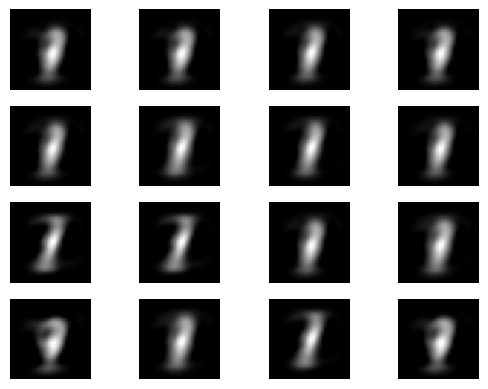

Epoch 17 completed in 2256.62 seconds
Generator Loss: 0.00015361358877075013
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:11<00:00,  7.86it/s]


Generation completed in 2206.65 seconds
Saved to generated_epoch_18.npy with shape (10000, 1, 28, 28)
Epoch 18 Generated Preview Images


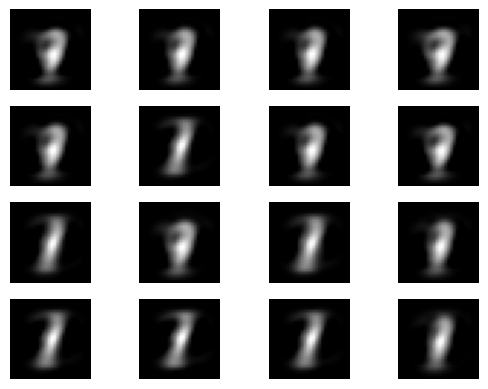

Epoch 18 completed in 2206.85 seconds
Generator Loss: 0.00013217501162435016
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:56<00:00,  7.59it/s]


Generation completed in 2250.89 seconds
Saved to generated_epoch_19.npy with shape (10000, 1, 28, 28)
Epoch 19 Generated Preview Images


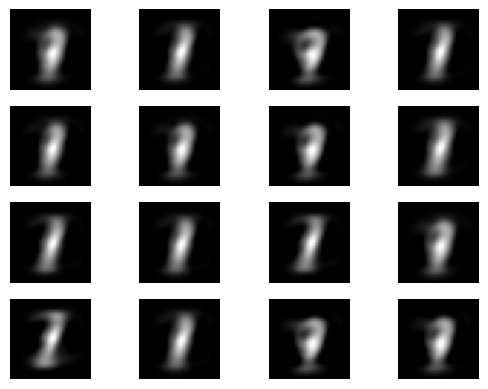

Epoch 19 completed in 2251.11 seconds


C:\Users\marco\AppData\Local\Temp\ipykernel_14596\1086685205.py:46: RuntimeWarning: invalid value encountered in scalar subtract
  df = 0.5 * (forward_diff - backward_diff)


Generator Loss: 0.00010717001029061948
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:37<00:00,  7.71it/s]


Generation completed in 2228.63 seconds
Saved to generated_epoch_20.npy with shape (10000, 1, 28, 28)
Epoch 20 Generated Preview Images


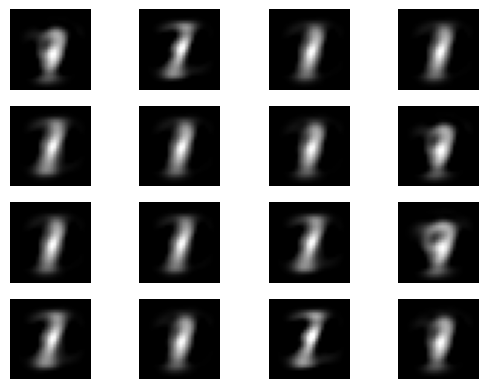

Epoch 20 completed in 2228.83 seconds
Generator Loss: 0.00010002715391035413
Discriminator Loss: 7.87871341219871
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:59<00:00,  7.58it/s]


Generation completed in 2252.90 seconds
Saved to generated_epoch_21.npy with shape (10000, 1, 28, 28)
Epoch 21 Generated Preview Images


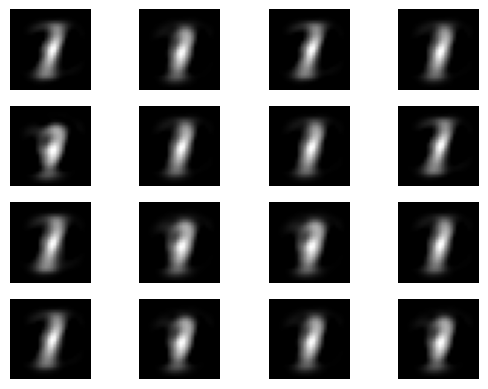

Epoch 21 completed in 2253.11 seconds
Generator Loss: 9.645501086267832e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:58<00:00,  7.58it/s]


Generation completed in 2255.13 seconds
Saved to generated_epoch_22.npy with shape (10000, 1, 28, 28)
Epoch 22 Generated Preview Images


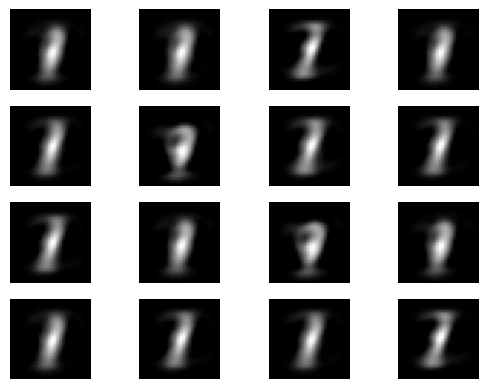

Epoch 22 completed in 2255.34 seconds
Generator Loss: 9.287857866974372e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [25:16<00:00,  6.59it/s]


Generation completed in 2484.05 seconds
Saved to generated_epoch_23.npy with shape (10000, 1, 28, 28)
Epoch 23 Generated Preview Images


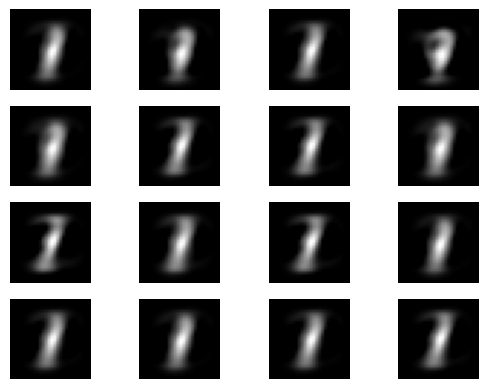

Epoch 23 completed in 2484.30 seconds
Generator Loss: 9.288000838482996e-05
Discriminator Loss: 7.8744975543525
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [27:04<00:00,  6.16it/s]


Generation completed in 2775.41 seconds
Saved to generated_epoch_24.npy with shape (10000, 1, 28, 28)
Epoch 24 Generated Preview Images


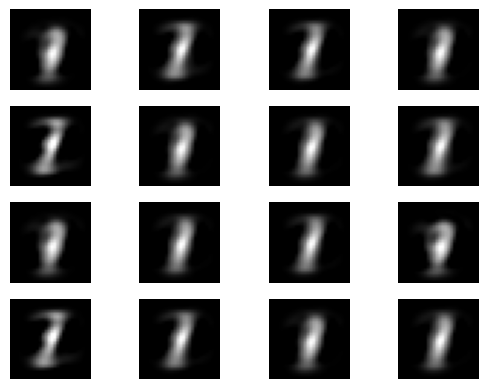

Epoch 24 completed in 2775.68 seconds
Generator Loss: 7.144572038368882e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:11<00:00,  7.51it/s]


Generation completed in 2292.37 seconds
Saved to generated_epoch_25.npy with shape (10000, 1, 28, 28)
Epoch 25 Generated Preview Images


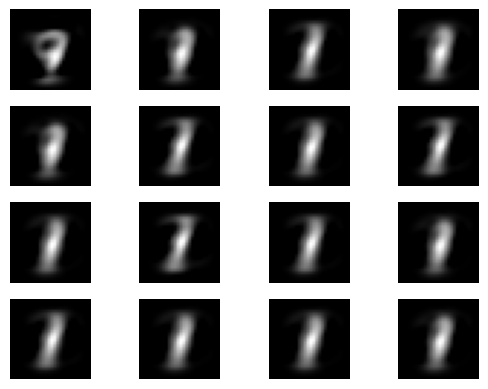

Epoch 25 completed in 2292.58 seconds
Generator Loss: 6.430000457325092e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:18<00:00,  7.47it/s]


Generation completed in 2291.24 seconds
Saved to generated_epoch_26.npy with shape (10000, 1, 28, 28)
Epoch 26 Generated Preview Images


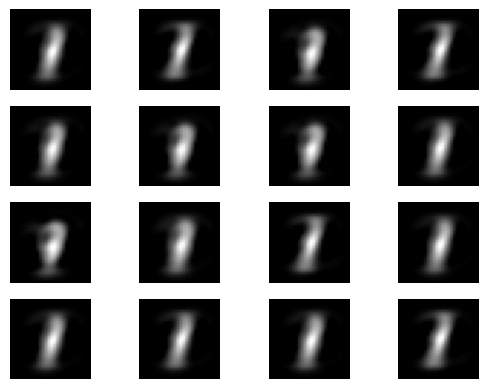

Epoch 26 completed in 2291.45 seconds
Generator Loss: 7.144572038368882e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:18<00:00,  7.47it/s]


Generation completed in 2290.46 seconds
Saved to generated_epoch_27.npy with shape (10000, 1, 28, 28)
Epoch 27 Generated Preview Images


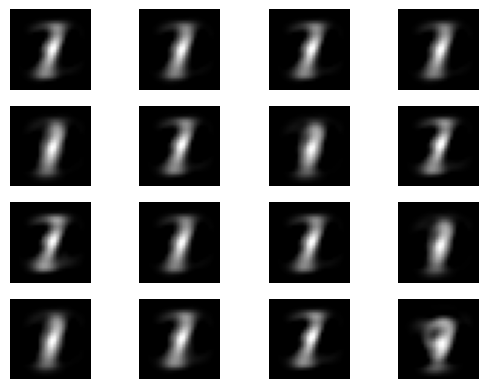

Epoch 27 completed in 2290.78 seconds
Generator Loss: 4.644071904995812e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:20<00:00,  7.46it/s]


Generation completed in 2292.78 seconds
Saved to generated_epoch_28.npy with shape (10000, 1, 28, 28)
Epoch 28 Generated Preview Images


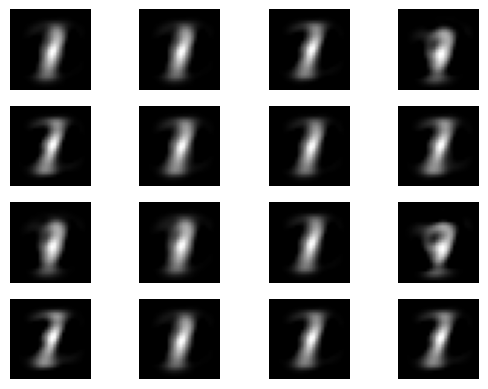

Epoch 28 completed in 2292.99 seconds
Generator Loss: 8.573715200456461e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:18<00:00,  7.47it/s]


Generation completed in 2291.32 seconds
Saved to generated_epoch_29.npy with shape (10000, 1, 28, 28)
Epoch 29 Generated Preview Images


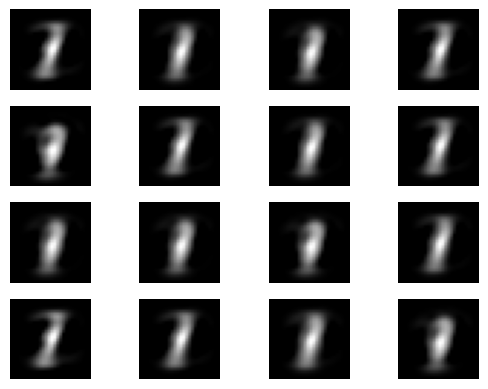

Epoch 29 completed in 2291.55 seconds
Generator Loss: 7.50192931464509e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:18<00:00,  7.47it/s]


Generation completed in 2289.99 seconds
Saved to generated_epoch_30.npy with shape (10000, 1, 28, 28)
Epoch 30 Generated Preview Images


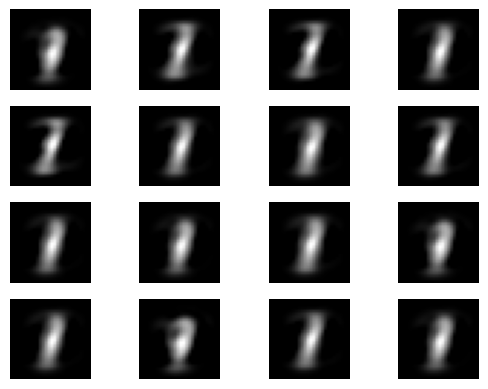

Epoch 30 completed in 2290.20 seconds
Generator Loss: 6.072643181048884e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:18<00:00,  7.47it/s]


Generation completed in 2289.59 seconds
Saved to generated_epoch_31.npy with shape (10000, 1, 28, 28)
Epoch 31 Generated Preview Images


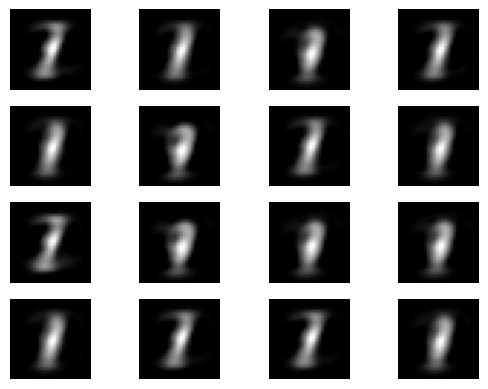

Epoch 31 completed in 2289.94 seconds
Generator Loss: 7.858714704886791e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:20<00:00,  7.46it/s]


Generation completed in 2292.12 seconds
Saved to generated_epoch_32.npy with shape (10000, 1, 28, 28)
Epoch 32 Generated Preview Images


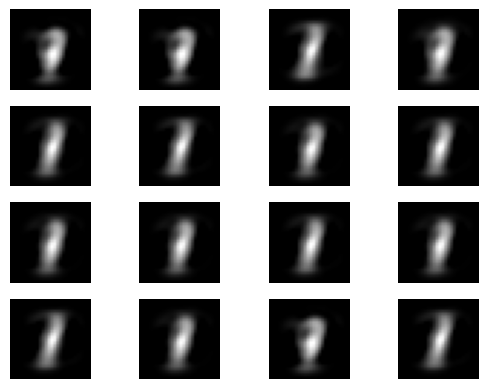

Epoch 32 completed in 2292.33 seconds
Generator Loss: 6.430143428833719e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:17<00:00,  7.47it/s]


Generation completed in 2290.45 seconds
Saved to generated_epoch_33.npy with shape (10000, 1, 28, 28)
Epoch 33 Generated Preview Images


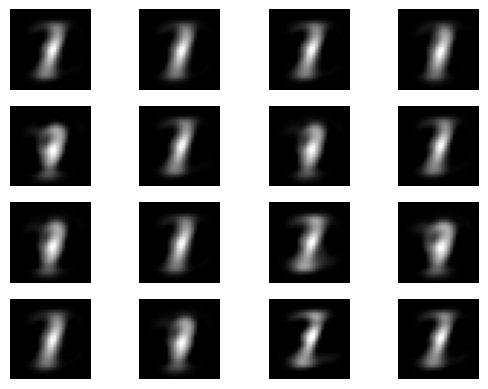

Epoch 33 completed in 2290.79 seconds
Generator Loss: 7.144715124369409e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:19<00:00,  7.46it/s]


Generation completed in 2290.03 seconds
Saved to generated_epoch_34.npy with shape (10000, 1, 28, 28)
Epoch 34 Generated Preview Images


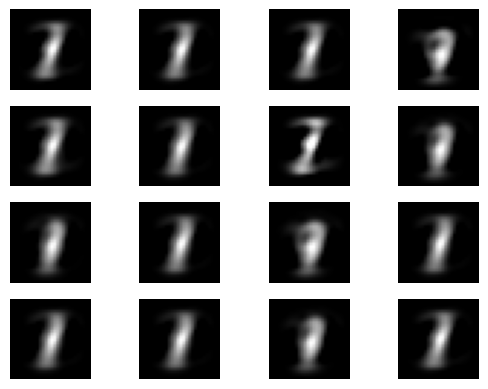

Epoch 34 completed in 2290.27 seconds
Generator Loss: 8.573286285930581e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:24<00:00,  7.44it/s]


Generation completed in 2300.50 seconds
Saved to generated_epoch_35.npy with shape (10000, 1, 28, 28)
Epoch 35 Generated Preview Images


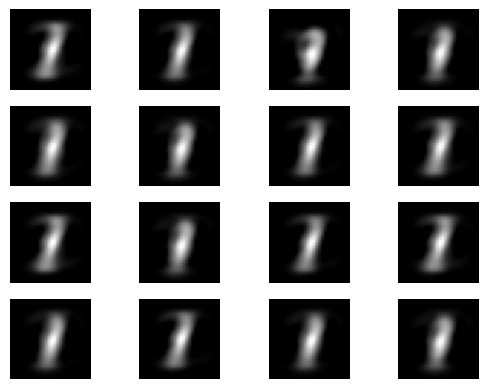

Epoch 35 completed in 2300.84 seconds
Generator Loss: 8.216357924180252e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:24<00:00,  7.44it/s]


Generation completed in 2304.40 seconds
Saved to generated_epoch_36.npy with shape (10000, 1, 28, 28)
Epoch 36 Generated Preview Images


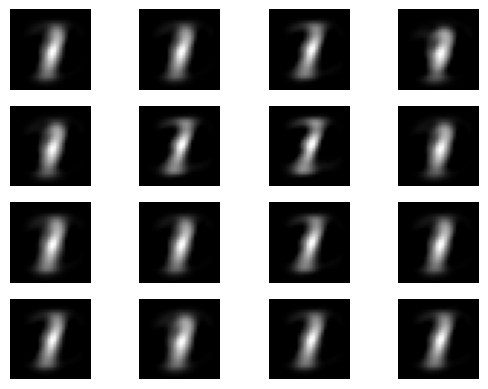

Epoch 36 completed in 2304.61 seconds
Generator Loss: 6.430000457325092e-05
Discriminator Loss: 7.861955583929622
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:22<00:00,  7.45it/s]


Generation completed in 2300.89 seconds
Saved to generated_epoch_37.npy with shape (10000, 1, 28, 28)
Epoch 37 Generated Preview Images


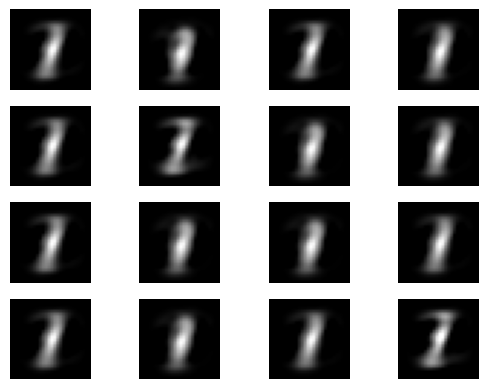

Epoch 37 completed in 2301.23 seconds
Generator Loss: 8.573286285930579e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:10<00:00,  7.52it/s]


Generation completed in 2286.73 seconds
Saved to generated_epoch_38.npy with shape (10000, 1, 28, 28)
Epoch 38 Generated Preview Images


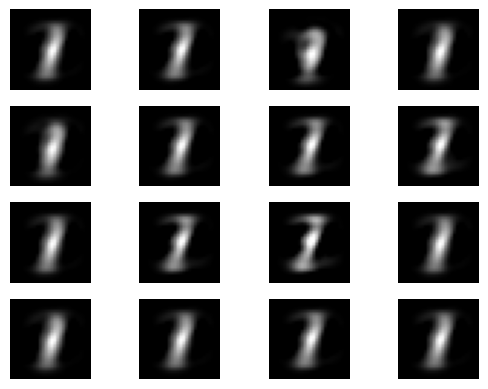

Epoch 38 completed in 2286.94 seconds
Generator Loss: 0.00011074501276846781
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:17<00:00,  7.83it/s]


Generation completed in 2233.06 seconds
Saved to generated_epoch_39.npy with shape (10000, 1, 28, 28)
Epoch 39 Generated Preview Images


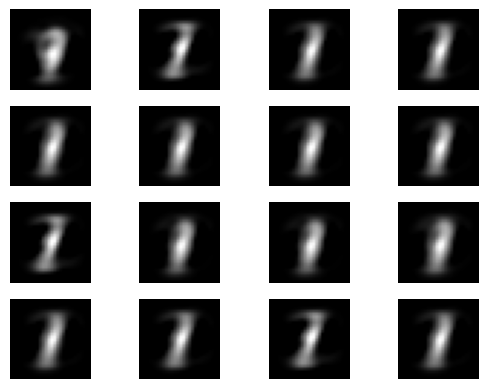

Epoch 39 completed in 2233.27 seconds
Generator Loss: 9.288000838482996e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:12<00:00,  7.86it/s]


Generation completed in 2213.35 seconds
Saved to generated_epoch_40.npy with shape (10000, 1, 28, 28)
Epoch 40 Generated Preview Images


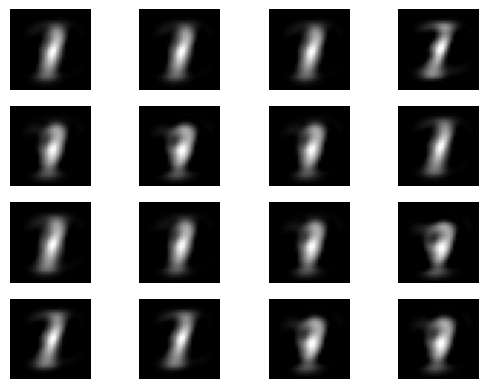

Epoch 40 completed in 2213.56 seconds
Generator Loss: 0.00011074358419830057
Discriminator Loss: 7.863618785976225
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:02<00:00,  7.56it/s]


Generation completed in 2269.79 seconds
Saved to generated_epoch_41.npy with shape (10000, 1, 28, 28)
Epoch 41 Generated Preview Images


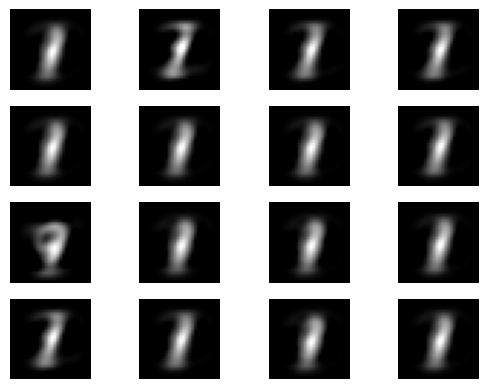

Epoch 41 completed in 2270.01 seconds
Generator Loss: 9.288143924483524e-05
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [24:02<00:00,  6.93it/s]


Generation completed in 2397.49 seconds
Saved to generated_epoch_42.npy with shape (10000, 1, 28, 28)
Epoch 42 Generated Preview Images


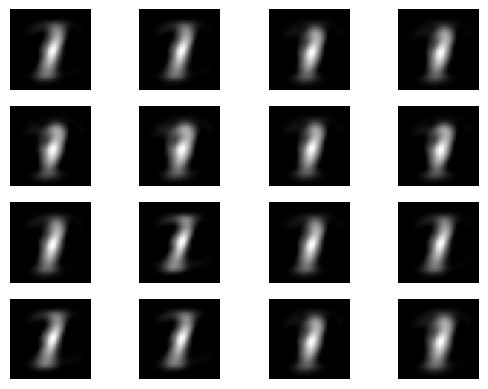

Epoch 42 completed in 2397.73 seconds
Generator Loss: 0.00010717144115062476
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [26:26<00:00,  6.30it/s]


Generation completed in 2695.69 seconds
Saved to generated_epoch_43.npy with shape (10000, 1, 28, 28)
Epoch 43 Generated Preview Images


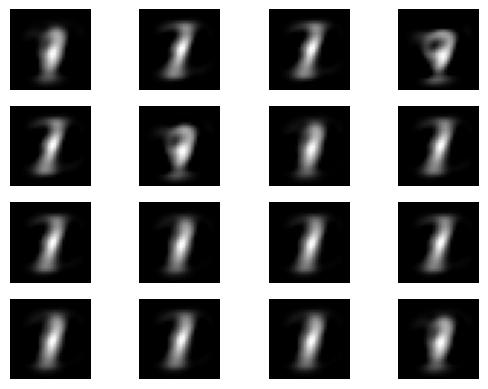

Epoch 43 completed in 2695.93 seconds
Generator Loss: 0.00011074644362847311
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:59<00:00,  7.25it/s]


Generation completed in 2539.73 seconds
Saved to generated_epoch_44.npy with shape (10000, 1, 28, 28)
Epoch 44 Generated Preview Images


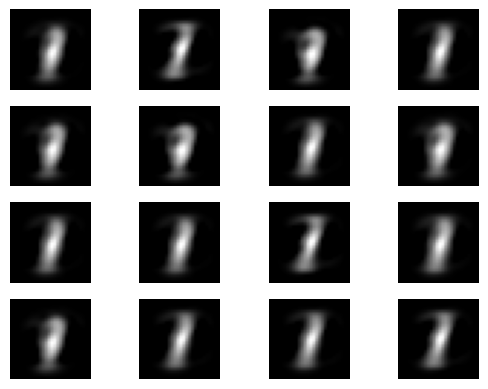

Epoch 44 completed in 2540.06 seconds
Generator Loss: 0.00011431858667614892
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [21:57<00:00,  7.59it/s]


Generation completed in 2279.27 seconds
Saved to generated_epoch_45.npy with shape (10000, 1, 28, 28)
Epoch 45 Generated Preview Images


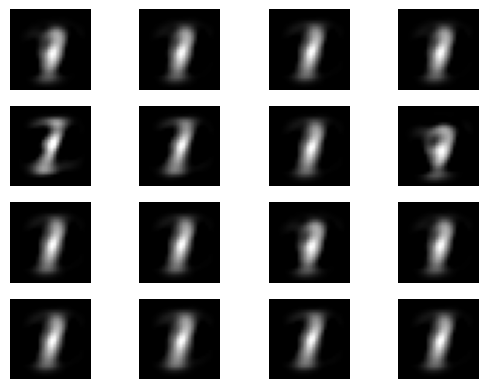

Epoch 45 completed in 2279.53 seconds
Generator Loss: 0.00011073786419303647
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [22:50<00:00,  7.30it/s]


Generation completed in 2406.46 seconds
Saved to generated_epoch_46.npy with shape (10000, 1, 28, 28)
Epoch 46 Generated Preview Images


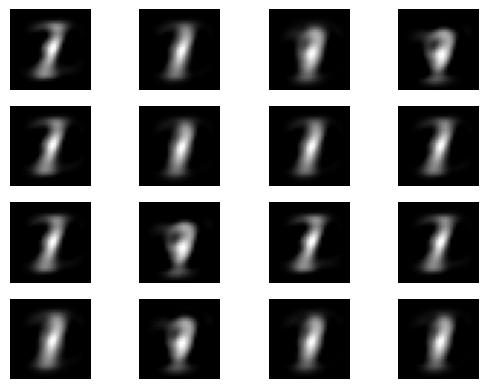

Epoch 46 completed in 2406.74 seconds
Generator Loss: 0.000121460013341328
Discriminator Loss: inf
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [25:14<00:00,  6.60it/s]


Generation completed in 2601.51 seconds
Saved to generated_epoch_47.npy with shape (10000, 1, 28, 28)
Epoch 47 Generated Preview Images


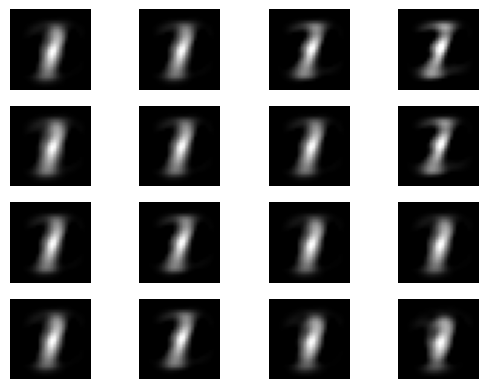

Epoch 47 completed in 2601.81 seconds
Generator Loss: 0.0002036278817283893
Discriminator Loss: 7.861955583929622
--------------------
Generating 10000 samples in parallel...


100%|██████████| 10000/10000 [25:15<00:00,  6.60it/s]


Generation completed in 2621.11 seconds
Saved to generated_epoch_48.npy with shape (10000, 1, 28, 28)
Epoch 48 Generated Preview Images


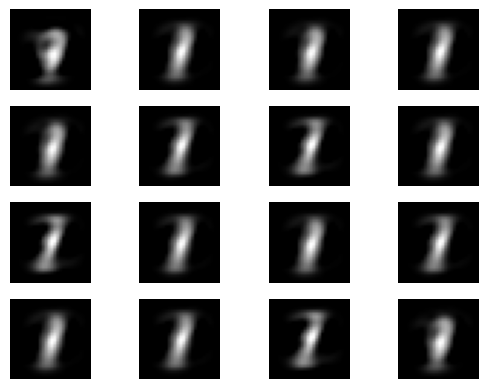

Epoch 48 completed in 2621.36 seconds


KeyboardInterrupt: 

In [6]:
q=5 # Set it to dimensionality of data *n 2 +. 1
c=1
tracked_kl_div_1 = []
tracked_kl_div_2 = []
# Initialize a quantum circuit with q qubits, and c cbits
# Initializt Ancilla qubit in equi-superposition
circ = QuantumCircuit(q,c)
circ.h(0)
layer_style = "Controlled-Dual"
train_var = init_random_variables(q-1,layer_style)

backend = AerSimulator(method='statevector')  # più veloce, più preciso

# Initial Learning Settings such as alpha etc.
tracked_d_loss = []
gradients = []
learning_rate=0.01
train_iter = 250
tracked_g_loss = []
gradients_g = []
corr = 0
wrong= 0 
loss_d_to_g = 0
loss_d_to_real = 0
tracked_loss_d_to_g = []
tracked_loss_d_to_real = []
train_on_fake = 5
df = [0,0]
print('Starting Training')
print('-'*20)



for epoch in np.arange(1, 100):
    start = time.time()
    par_shift = 0.5 * np.pi * np.sqrt(1 / (epoch + 1))

    # -- Training Discriminatore --
    for _ in range(1):
        for key, value in train_var.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = cost_function(get_probabilities(disc_fake_training_circuit(train_var, key, key_value, diff=True, fwd_diff=True)), 1, None)
                backward_diff = cost_function(get_probabilities(disc_fake_training_circuit(train_var, key, key_value, diff=True, fwd_diff=False)), 1, None)
                df = 0.5 * (forward_diff - backward_diff)
                if abs(df) > 1:
                    df = df / abs(df)

    for index, point in enumerate(pca_data_rot):
        df = [0, 0]
        gradients = []
        loss = [0, 0]
        for key, value in train_var.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = cost_function(get_probabilities(disc_real_training_circuit(train_var, point, key, key_value, diff=True, fwd_diff=True)), 0, None)
                backward_diff = cost_function(get_probabilities(disc_real_training_circuit(train_var, point, key, key_value, diff=True, fwd_diff=False)), 0, None)
                df = 0.5 * (forward_diff - backward_diff)
                train_var[key][key_value] -= learning_rate * df
        loss[0] += cost_function(get_probabilities(disc_real_training_circuit(train_var, point, key, key_value, diff=False, fwd_diff=False)), 0, None)
        loss[1] += 1

    # -- Training Generatore --
    loss_g = [0, 0]
    for _ in range(len(pca_data_rot) // 10):
        gen_params = True
        for key, value in train_var.items():
            if str(q // 2 + 1) not in key and gen_params:
                continue
            else:
                gen_params = False
            for key_value in range(len(value)):
                forward_diff = generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var[key][key_value] -= df * learning_rate * 2.5
        loss_g[0] += generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var, key, key_value, diff=False, fwd_diff=False)))
        loss_g[1] += 1

    print(f"Generator Loss: {loss_g[0] / loss_g[1]}")
    tracked_g_loss.append(loss_g[0] / loss_g[1])
    loss_qgan = cost_function(get_probabilities(disc_fake_training_circuit(train_var, key, key_value, diff=False, fwd_diff=False)), 1, None)
    t_loss = loss_qgan + (loss[0] / loss[1])
    tracked_loss_d_to_real.append(loss[0] / loss[1])
    tracked_loss_d_to_g.append(loss_qgan)
    print(f"Discriminator Loss: {t_loss}")
    tracked_d_loss.append(t_loss)
    print("-" * 20)

    # -- Generazione parallela di 10.000 immagini con tqdm --
    print(f"Generating 10000 samples in parallel...")
    circ = disc_fake_training_circuit(train_var, point, key, key_value, Sample=True)
    n_generated = 10000
    n_results = q // 2
    
    def simulate_single():
        circ_t = transpile(circ, backend)
        job = backend.run(circ_t, shots=20)
        result = job.result()
        counts = result.get_counts(circ_t)
        bins = [[0, 0] for _ in range(n_results)]
        for key, value in counts.items():
            for i in range(n_results):
                if key[-i - 1] == '1':
                    bins[i][0] += value
                bins[i][1] += value
        for i, pair in enumerate(bins):
            bins[i] = pair[0] / pair[1]
        return bins

    with ThreadPoolExecutor(max_workers=8) as executor:
        data = list(tqdm(executor.map(lambda _: simulate_single(), range(n_generated)), total=n_generated))

    print(f"Generation completed in {time.time() - start:.2f} seconds")

    new_info = descale_points(np.array(data))
    new_info = new_info.reshape(new_info.shape[0], 28, 28)
    generated = np.clip(new_info, 0, 1).astype(np.float32)
    generated = generated[:, np.newaxis, :, :]
    np.save(f"generated_epoch_{epoch}.npy", generated)
    print(f"Saved to generated_epoch_{epoch}.npy with shape {generated.shape}")

    print(f"Epoch {epoch} Generated Preview Images")
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated[i, 0, :, :], cmap='gray')
        plt.axis('off')
    plt.savefig(f"qgan_ICLR_epoch_{epoch}_preview.png")
    plt.show()

    with open(f'new_qgan_results_mnis_epoch_ICLR_{epoch}.txt', 'w') as file:
        file.write("Tracked KL Divergence\n")
        file.write(str(tracked_kl_div_1) + "\n")
        file.write("Loss Of Generator\n")
        file.write(str(tracked_g_loss) + "\n")
        file.write("Loss Of Discriminator\n")
        file.write(str(tracked_d_loss) + "\n")

    save_variables(train_var, epoch)
    print(f"Epoch {epoch} completed in {time.time() - start:.2f} seconds")


In [1]:
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms

# Load MNIST train set
mnist = MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

# Select only digit '1'
ones = [img.numpy() for img, label in mnist if label == 1]

# Stack to shape (N, 1, 28, 28)
ones_np = np.stack(ones)

# Save as .npy file
np.save("mnist_ones.npy", ones_np)
print("Saved mnist_ones.npy with shape:", ones_np.shape)

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.34MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 280kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.76MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]


Saved mnist_ones.npy with shape: (6742, 1, 28, 28)


In [1]:
import torch
import numpy as np
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance
from torchmetrics.image.fid import FrechetInceptionDistance

# ===> Percorsi ai file
real_path = r"C:\Users\marco\Desktop\Università\courses\Generative Deep Learning\code\mnist_ones.npy"
fake_path = r"C:\Users\marco\Desktop\Università\courses\Generative Deep Learning\code\generated_epoch_20.npy"

# ===> Parametri immagine
c, h, w = 1, 28, 28

# ===> Caricamento immagini
real_np = np.load(real_path)
fake_np = np.load(fake_path)

# ===> Normalizzazione e conversione in tensor (range 0–255 come uint8)
real_images = torch.clamp(torch.from_numpy(real_np * 255), 0, 255).to(torch.uint8).view(-1, c, h, w)
fake_images = torch.clamp(torch.from_numpy(fake_np * 255), 0, 255).to(torch.uint8).view(-1, c, h, w)

# Per Inception serve input RGB (3 canali)
real_tensor = real_images.repeat(1, 3, 1, 1) if c == 1 else real_images
fake_tensor = fake_images.repeat(1, 3, 1, 1) if c == 1 else fake_images

# ===> Funzioni di valutazione
def calculate_is(fake_torch):
    is_metric = InceptionScore()
    batch_size = 100
    for i in range(0, len(fake_torch), batch_size):
        batch = fake_torch[i:i+batch_size]
        if batch.shape[0] == 0:
            continue
        is_metric.update(batch)
    return is_metric.compute()

def calculate_kid(real_torch, fake_torch):
    kid = KernelInceptionDistance()
    batch_size = 100
    for i in range(0, min(len(fake_torch), len(real_torch)), batch_size):
        real_batch = real_torch[i:i+batch_size]
        fake_batch = fake_torch[i:i+batch_size]
        if real_batch.shape[0] == 0 or fake_batch.shape[0] == 0:
            continue
        kid.update(real_batch, real=True)
        kid.update(fake_batch, real=False)
    return kid.compute()

def calculate_fid(real_torch, fake_torch):
    fid = FrechetInceptionDistance(feature=2048)
    batch_size = 100
    for i in range(0, min(len(fake_torch), len(real_torch)), batch_size):
        real_batch = real_torch[i:i+batch_size]
        fake_batch = fake_torch[i:i+batch_size]
        if real_batch.shape[0] == 0 or fake_batch.shape[0] == 0:
            continue
        fid.update(real_batch, real=True)
        fid.update(fake_batch, real=False)
    return fid.compute()

# ===> Esecuzione
fid_result = calculate_fid(real_tensor, fake_tensor)
kid_result = calculate_kid(real_tensor, fake_tensor)
is_result = calculate_is(fake_tensor)

print(f"\n📊 Evaluation Results:\n  FID = {fid_result}\n  KID = {kid_result}\n  IS  = {is_result}")


c:\Users\marco\anaconda3\envs\quantum\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\marco\anaconda3\envs\quantum\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



📊 Evaluation Results:
  FID = 266.3597717285156
  KID = (tensor(0.3514), tensor(0.0023))
  IS  = (tensor(1.2780), tensor(0.0082))
